In [6]:
from carts_poles import CartsPolesEnv
import torch
import torch.nn
import numpy as np
import random
import gym
from collections import namedtuple
from collections import deque
from typing import List, Tuple
import matplotlib.pyplot as plt
import time

In [14]:
# Hyper parms!!
global FLAGS

FLAGS = {
    "gamma" : 0.99,
    
    "n_episode" : 100,

    "batch_size" : 64,

    "hidden_dim" : 12,

    "capacity" : 50000,

    "max_episode" : 50,

    "min_eps" : 0.01
}

In [8]:
class DQN(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int) -> None:
        """DQN Network
        Args:
            input_dim (int): `state` dimension.
                `state` is 2-D tensor of shape (n, input_dim)
            output_dim (int): Number of actions.
                Q_value is 2-D tensor of shape (n, output_dim)
            hidden_dim (int): Hidden dimension in fc layer
        """
        super(DQN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.PReLU()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.PReLU()
        )

        self.final = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns a Q_value
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, input_dim)
        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, output_dim)
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.final(x)

        return x

class ReplayMemory(object):

    def __init__(self, capacity: int) -> None:
        """Replay memory class
        Args:
            capacity (int): Max size of this memory
        """
        self.capacity = capacity
        self.cursor = 0
        self.memory = []

    def push(self,
             state: np.ndarray,
             action: int,
             reward: int,
             next_state: np.ndarray,
             done: bool) -> None:
        """Creates `Transition` and insert
        Args:
            state (np.ndarray): 1-D tensor of shape (input_dim,)
            action (int): action index (0 <= action < output_dim)
            reward (int): reward value
            next_state (np.ndarray): 1-D tensor of shape (input_dim,)
            done (bool): whether this state was last step
        """
        if len(self) < self.capacity:
            self.memory.append(None)

        self.memory[self.cursor] = Transition(state,
                                              action, reward, next_state, done)
        self.cursor = (self.cursor + 1) % self.capacity

    def pop(self, batch_size: int) -> List[Transition]:
        """Returns a minibatch of `Transition` randomly
        Args:
            batch_size (int): Size of mini-bach
        Returns:
            List[Transition]: Minibatch of `Transition`
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Returns the length """
        return len(self.memory)


class Agent(object):

    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int) -> None:
        """Agent class that choose action and train
        Args:
            input_dim (int): input dimension
            output_dim (int): output dimension
            hidden_dim (int): hidden dimension
        """
        self.dqn = DQN(input_dim, output_dim, hidden_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.loss_fn = torch.nn.MSELoss()
        self.optim = torch.optim.Adam(self.dqn.parameters())

    def _to_variable(self, x: np.ndarray) -> torch.Tensor:
        """torch.Variable syntax helper
        Args:
            x (np.ndarray): 2-D tensor of shape (n, input_dim)
        Returns:
            torch.Tensor: torch variable
        """
        return torch.autograd.Variable(torch.Tensor(x))

    def get_action(self, states: np.ndarray, eps: float) -> int:
        """Returns an action
        Args:
            states (np.ndarray): 2-D tensor of shape (n, input_dim)
            eps (float): 𝜺-greedy for exploration
        Returns:
            int: action index
        """
        if np.random.rand() < eps:
            return np.random.choice(self.output_dim)
        else:
            self.dqn.train(mode=False)
            scores = self.get_Q(states)
            _, argmax = torch.max(scores.data, 1)
            return int(argmax.numpy())

    def get_Q(self, states: np.ndarray) -> torch.FloatTensor:
        """Returns `Q-value`
        Args:
            states (np.ndarray): 2-D Tensor of shape (n, input_dim)
        Returns:
            torch.FloatTensor: 2-D Tensor of shape (n, output_dim)
        """
        states = self._to_variable(states.reshape(-1, self.input_dim))
        self.dqn.train(mode=False)
        return self.dqn(states)

    def train(self, Q_pred: torch.FloatTensor, Q_true: torch.FloatTensor) -> float:
        """Computes `loss` and backpropagation
        Args:
            Q_pred (torch.FloatTensor): Predicted value by the network,
                2-D Tensor of shape(n, output_dim)
            Q_true (torch.FloatTensor): Target value obtained from the game,
                2-D Tensor of shape(n, output_dim)
        Returns:
            float: loss value
        """
        self.dqn.train(mode=True)
        self.optim.zero_grad()
        loss = self.loss_fn(Q_pred, Q_true)
        loss.backward()
        self.optim.step()

        return loss


def train_helper(agent: Agent, minibatch: List[Transition], gamma: float) -> float:
    """Prepare minibatch and train them
    Args:
        agent (Agent): Agent has `train(Q_pred, Q_true)` method
        minibatch (List[Transition]): Minibatch of `Transition`
        gamma (float): Discount rate of Q_target
    Returns:
        float: Loss value
    """
    states = np.vstack([x.state for x in minibatch])
    actions = np.array([x.action for x in minibatch])
    rewards = np.array([x.reward for x in minibatch])
    next_states = np.vstack([x.next_state for x in minibatch])
    done = np.array([x.done for x in minibatch])

    Q_predict = agent.get_Q(states)
    Q_target = Q_predict.clone().data.numpy()
    Q_target[np.arange(len(Q_target)), actions] = rewards + gamma * np.max(agent.get_Q(next_states).data.numpy(), axis=1) * ~done
    Q_target = agent._to_variable(Q_target)

    return agent.train(Q_predict, Q_target)


def play_episode(env: gym.Env,
                 agent: Agent,
                 replay_memory: ReplayMemory,
                 eps: float,
                 batch_size: int,
                 render = False) -> int:
    """Play an epsiode and train
    Args:
        env (gym.Env): gym environment (CartPole-v0)
        agent (Agent): agent will train and get action
        replay_memory (ReplayMemory): trajectory is saved here
        eps (float): 𝜺-greedy for exploration
        batch_size (int): batch size
    Returns:
        int: reward earned in this episode
    """
    s = env.reset()
    done = False
    total_reward = 0

    while not done:

        a = agent.get_action(s, eps)
        s2, r, done, info = env.step(a)

        if render == True:
            env.render()

        total_reward += r

        if done:
            r = -1
        replay_memory.push(s, a, r, s2, done)

        if len(replay_memory) > batch_size:

            minibatch = replay_memory.pop(batch_size)
            train_helper(agent, minibatch, FLAGS["gamma"])

        s = s2

    return total_reward


def get_env_dim(env: gym.Env) -> Tuple[int, int]:
    """Returns input_dim & output_dim
    Args:
        env (gym.Env): gym Environment (CartPole-v0)
    Returns:
        int: input_dim
        int: output_dim
    """
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    return input_dim, output_dim


def epsilon_annealing(epsiode: int, max_episode: int, min_eps: float) -> float:
    """Returns 𝜺-greedy
    1.0---|\
          | \
          |  \
    min_e +---+------->
              |
              max_episode
    Args:
        epsiode (int): Current episode (0<= episode)
        max_episode (int): After max episode, 𝜺 will be `min_eps`
        min_eps (float): 𝜺 will never go below this value
    Returns:
        float: 𝜺 value
    """

    slope = (min_eps - 1.0) / max_episode
    return max(slope * epsiode + 1.0, min_eps)

[Episode:     1] Reward: 0.6700000000000004 𝜺-greedy:  1.00
[Episode:    11] Reward: 0.6600000000000004 𝜺-greedy:  0.80
[Episode:    21] Reward: 0.5800000000000003 𝜺-greedy:  0.60
[Episode:    31] Reward: 0.5600000000000003 𝜺-greedy:  0.41
[Episode:    41] Reward: 0.2700000000000001 𝜺-greedy:  0.21
[Episode:    51] Reward: 0.3900000000000002 𝜺-greedy:  0.01
[Episode:    61] Reward: 0.37000000000000016 𝜺-greedy:  0.01
[Episode:    71] Reward: 0.5300000000000002 𝜺-greedy:  0.01
[Episode:    81] Reward: 0.3900000000000002 𝜺-greedy:  0.01
[Episode:    91] Reward: 0.5100000000000002 𝜺-greedy:  0.01


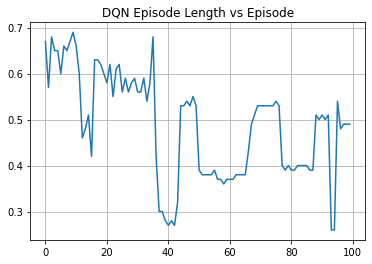

AttributeError: module 'torch' has no attribute 'DQN'

In [15]:
Transition = namedtuple("Transition",
                        field_names=["state", "action", "reward", "next_state", "done"])


env = CartsPolesEnv()
rewards = np.zeros(FLAGS['n_episode'])
input_dim, output_dim = get_env_dim(env)
agent = Agent(input_dim, output_dim, FLAGS['hidden_dim'])
replay_memory = ReplayMemory(FLAGS['capacity'])

for i in range(FLAGS['n_episode']):
    render = False
    eps = epsilon_annealing(i, FLAGS['max_episode'], FLAGS['min_eps'])

    if (i % 50 == 0): render = False

    r = play_episode(env, agent, replay_memory, eps,FLAGS['batch_size'],render)
    if (i % 10 == 0): print("[Episode: {:5}] Reward: {:5} 𝜺-greedy: {:5.2f}".format(i + 1, r, eps))

    rewards[i] = r

    # if len(rewards) == rewards.maxlen:
    #     if np.mean(rewards) >= 200:
    #         print("Game cleared in {} games with {}".format(i + 1, np.mean(rewards)))
    #         break

# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(range(0,FLAGS['n_episode']),rewards)
# ax2.plot(range(0,n_episode),td_error,c='g')
plt.title("DQN Episode Length vs Episode")
# ax2.title.set_text("TD Error Convergence")
# fig.suptitle('DQN Control')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
plt.grid()
# ax2.grid()
plt.show()

torch.save(DQN.state_dict(), 'DQN.pt')

In [60]:
import pickle
r,history = pickle.load(open('Episodes/BestEpisode_18_05_2021_23_29_43.p', "rb" ))

In [62]:
history

[(array([-0.75      ,  0.        ,  0.75      ,  0.75      , -0.78539816,
          0.        , -2.35619449,  0.        ,  0.        ,  0.        ,
          0.        ,  1.19852814]),
  8,
  0.01),
 (array([-7.50000000e-01,  1.58045539e-02,  7.50000000e-01,  7.50000000e-01,
         -7.85398163e-01,  1.96514151e-03, -2.35619449e+00, -2.28818929e-02,
          0.00000000e+00,  3.54159814e-02,  0.00000000e+00,  1.19852814e+00]),
  8,
  0.01),
 (array([-7.49841954e-01,  2.92333469e-02,  7.49803622e-01,  7.49803622e-01,
         -7.85378512e-01,  2.01255962e-02, -2.35642331e+00, -1.24304947e-01,
          3.54159814e-04,  3.80129235e-02,  4.25109831e-05,  1.19848663e+00]),
  8,
  0.01),
 (array([-7.49549621e-01,  4.02127537e-02,  7.49487022e-01,  7.49487022e-01,
         -7.85177256e-01,  5.14709926e-02, -2.35766636e+00, -5.45971488e-02,
          7.34289049e-04,  4.39244351e-03,  8.77273354e-05,  1.19862794e+00]),
  8,
  0.01),
 (array([-7.49147493e-01,  5.26892703e-02,  7.49069330e-01, 

In [67]:
import os.path
from os import path

path.exists("DQN.pt")



True